In [ ]:
import os, re, csv, sys, codecs, pickle
from datetime import datetime

from unidecode import unidecode
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, LSTM
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import FrenchStemmer, SnowballStemmer
import livelossplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import MultiLabelBinarizer

sys.path.append('../utils')
from utils import *

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,10)

In [2]:
# parameters
level = 'PT'
min_occurence = 10

In [3]:
if level == 'HLT':
    with open('hlt_counts.pkl', 'rb') as file:
        tag_counts = pickle.load(file)
elif level == 'PT':  
    with open('pt_counts.pkl', 'rb') as file:
        tag_counts = pickle.load(file)
else:
    raise ValueError('bad level "{}", "PT" or "HLT" expected'.format(level))

## data processing

In [4]:
with open('dataset.pkl', 'rb') as file:
    data = pickle.load(file)
    
with open('tags.pkl', 'rb') as file:
    tags = pickle.load(file)
if level == 'HLT':   
    tags = dict(zip(tags["Cas CRPV"].values, [[s for s in pt_to_hlt(t) if tag_counts[s]>=min_occurence] for t in tags["PT"].values]))
else:
    tags = dict(zip(tags["Cas CRPV"].values, [[s for s in t if tag_counts[s]>=min_occurence] for t in tags["PT"].values]))
    
X = []
Y = []
ctr = 0
for k, df in data.items():
    try:
        Y.append(tags[k])
        feat = get_features(df[1])
        X.append(' '.join([feat[0], 5*feat[3]]))
    except:
        ctr += 1

tag_binarizer = MultiLabelBinarizer()


error computing imc
error computing imc


In [ ]:
"""
'dataset.pkl' contains your dataset of features, it is a dict with unique key corresponding to each case.
"""
with open('dataset.pkl', 'rb') as file:
    data = pickle.load(file)
    
"""
'regex_match.pkl' contains meddra terms matched to each case using a regex engine.
    it is a dict with the same key as for 'dataset.pkl'.
"""
with open('regex_match.pkl', 'rb') as file:
    regex_match = pickle.load(file)

"""
'tags.pkl' contains the meddra tags that correspond to your dataset, it is a dict with the same key as for 'dataset.pkl'.
    We only keep the most common terms (i.e with number of occurences greater than the min_occurence parameter.)
""" 
with open('tags.pkl', 'rb') as file:
    tags = pickle.load(file)
    
X = []
Y = []
re_match = []
"""
    We build the X and Y arrays from our features and tags.
    X components are tokenized text contents of the case report forms,
    it does not need to be vectorized at this time of the pipeline.
"""
for key, value in data.items():
    X.append(value)
    Y.append(tags[key])
    re_match.append(regex_match[key])

## Test - train split

In [6]:
X_train, X_test, Y_train, Y_test, regex_train, regex_test = train_test_split(X, Y, re_match, test_size=0.2, random_state=42)

## Tags binarization and TF-IDF

In [ ]:
Y_train = tag_binarizer.fit_transform(Y_train)
Y_test = tag_binarizer.transform(Y_test)

regex_test_bin = tag_binarizer.transform(regex_test)
regex_test_filtered = [[s for s in l if s in tag_counts.keys() and tag_counts[s] >= min_occurence] for l in regex_test]

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

"""
    We turn the text features into sequences to it the input format expected by the LSTM.
"""
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
np.random.seed(0)

EMBEDDING_PATH = 'path_to_your_pre-trained_fasttext_embedding'

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('french'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

"""
    loading embeddings
"""
embeddings_index = {}
f = codecs.open(
    EMBEDDING_PATH,
    encoding='utf-8'
)
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

In [ ]:
"""
    Preparing text data.
"""
processed_docs_train = []
for doc in tqdm(X_train):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))

processed_docs_test = []
for doc in tqdm(X_test):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))

In [17]:
max_seq_len = 150
print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)


tokenizing input data...
dictionary size:  3917


## Computing fasttext embedding

In [18]:
# training params
batch_size = 256 
num_epochs = 100

# model parameters
num_filters = 64 
embed_dim = 100 
weight_decay = 1e-4

In [19]:
"""
    preparing embedding matrix...
"""
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2130


## Models training

In [20]:
"""
    Defining the model architecture.
"""
model = Sequential()
model.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix],
          input_length=max_seq_len, trainable=True))
model.add(Dropout(0.2))
model.add(LSTM(60))
model.add(Dropout(0.2))
model.add(Dense(nb_class, activation='sigmoid'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          391700    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                38640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 125)               7625      
Total params: 437,965
Trainable params: 437,965
Non-trainable params: 0
_______________

In [21]:
"""
    Training
"""
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = []#[early_stopping]

history = model.fit(word_seq_train, Y_train, epochs=50, batch_size=16, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)
# Final evaluation of the model
scores = model.evaluate(word_seq_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Use tf.cast instead.
Train on 1481 samples, validate on 165 samples
Epoch 1/50
 - 12s - loss: 22.2960 - acc: 0.2046 - val_loss: 20.7110 - val_acc: 0.2061
Epoch 2/50
 - 11s - loss: 20.9741 - acc: 0.2221 - val_loss: 20.5087 - val_acc: 0.2061
Epoch 3/50
 - 11s - loss: 20.8716 - acc: 0.2228 - val_loss: 20.4329 - val_acc: 0.2061
Epoch 4/50
 - 11s - loss: 20.6877 - acc: 0.2235 - val_loss: 20.2647 - val_acc: 0.2061
Epoch 5/50
 - 11s - loss: 20.5165 - acc: 0.2242 - val_loss: 20.1252 - val_acc: 0.2061
Epoch 6/50
 - 12s - loss: 20.3618 - acc: 0.2242 - val_loss: 20.0648 - val_acc: 0.2061
Epoch 7/50
 - 11s - loss: 20.2700 - acc: 0.2242 - val_loss: 19.9806 - val_acc: 0.2061
Epoch 8/50
 - 11s - loss: 20.1813 - acc: 0.2242 - val_loss: 19.9471 - val_acc: 0.2061
Epoch 9/50
 - 12s - loss: 20.0860 - acc: 0.2242 - val_loss: 19.8863 - val_acc: 0.2061
Epoch 10/50
 - 11s - loss: 20.0201 - acc: 0.2242 - val_loss: 19.8674 - val_acc: 0.2061
Epoch 11/50
 - 11s - loss: 19.9110 - acc: 0.

In [22]:
"""
    Predictions on the test set
"""
pred = model.predict_proba(word_seq_test)
pred_flat = np.hstack(pred)

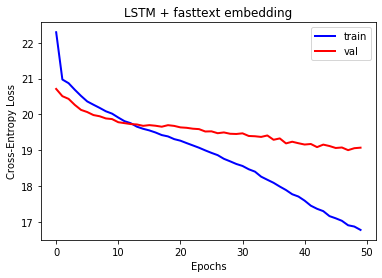

In [18]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM + fasttext embedding')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

## ROC curves and AUC

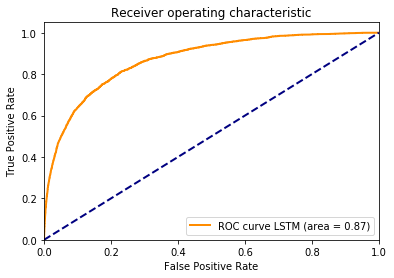

In [20]:
fpr, tpr, _ = roc_curve(Y_test.flatten('C'), pred_flat)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve LSTM (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Precision - recall per model

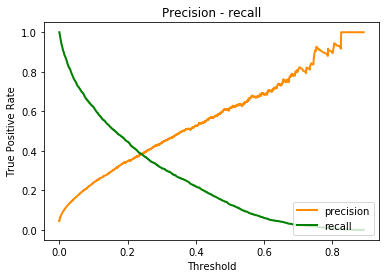

In [21]:
p, r, t = precision_recall_curve(Y_test.flatten('C'), pred_flat)
plt.figure()
lw = 2
plt.plot([0]+list(t), p, color='darkorange',
         lw=lw, label='precision')
plt.plot([0]+list(t), r, color='green',
         lw=lw, label='recall')
plt.xlabel('Threshold')
plt.ylabel('True Positive Rate')
plt.title('Precision - recall')
plt.legend(loc="lower right")
plt.show()

In [22]:
F1 = 2 * (p * r) / (p + r)
F1 = [x if x==x else 0 for x in F1]
th = t[np.argmax(F1)]
tn, fp, fn, tp = confusion_matrix(Y_test.flatten('C'), [0 if x < th else 1 for x in pred_flat]).ravel()
max(F1), tp, fn, fp, tn, th

(0.39328808446455504, 1043, 1207, 2011, 47239, 0.18967676)